In [1]:
import data
import glob
import os
import torch
import torchsig

import numpy as np
import torch.nn.functional as F
import torchsig.transforms as ST

from datetime import datetime
from matplotlib import pyplot as plt
from models import CustomNetwork
from pathlib import Path
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sigmf_db_dataset import SigMFDB
from sigmf_pytorch_dataset import SigMFDataset
from sklearn.metrics import classification_report
from torch import optim
from torch.utils.data import DataLoader
from torchsig.datasets.sig53 import Sig53
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b4
from torchsig.transforms import (
    Compose,
    IQImbalance,
    Normalize,
    RandomApply,
    RandomFrequencyShift,
    RandomPhaseShift,
    RandomResample,
    RandomTimeShift,
    RayleighFadingChannel,
    TargetSNR,
    ComplexTo2D,
)
from torchsig.utils.cm_plotter import plot_confusion_matrix
from torchsig.utils.dataset import SignalDataset
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer, two_channel_to_complex
from tqdm import tqdm
from typing import List


# Annotate data (only required once)

In [2]:

def annotate_emair(filename, label):
    
    data_obj = data.Data(filename)
    iq_samples = data_obj.get_samples()

    data_obj.sigmf_obj._metadata[data_obj.sigmf_obj.ANNOTATION_KEY] = []
    
    start = 0
    length = len(iq_samples)
    
    metadata = {
        "core:label": label,
        "core:freq_lower_edge": data_obj.metadata["captures"][0]["core:frequency"]
        - data_obj.metadata["global"]["core:sample_rate"] / 2,
        "core:freq_upper_edge": data_obj.metadata["captures"][0]["core:frequency"]
        + data_obj.metadata["global"]["core:sample_rate"] / 2,
    }
    data_obj.sigmf_obj.add_annotation(start, length=length, metadata=metadata)

    data_obj.sigmf_obj.tofile(data_obj.sigmf_meta_filename, skip_validate=True)


In [3]:
num_iq_samples = 500

# Annotate anomalous data 
dataset_path = "./data/emair_wifi/20msps/mod/**/"
for f in glob.glob(dataset_path+"*.sigmf-meta", recursive=True):
    annotate_emair(f, label="anom_wifi")

# Annotate normal data 
dataset_path = "./data/emair_wifi/20msps/normal/**/"
for f in glob.glob(dataset_path+"*.sigmf-meta", recursive=True):
    annotate_emair(f, label="wifi")



Loaded 
 Data file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-33.sigmf-data 
 SigMF-Meta file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-33.sigmf-meta


Loaded 
 Data file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-25.sigmf-data 
 SigMF-Meta file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-25.sigmf-meta


Loaded 
 Data file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-26.sigmf-data 
 SigMF-Meta file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-26.sigmf-meta


Loaded 
 Data file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-29.sigmf-data 
 SigMF-Meta file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-29.sigmf-meta


Loaded 
 Data file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-14.sigmf-data 
 SigMF-Meta file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-14.sigmf-meta


Loaded 
 Data file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-23.sigmf-data 
 SigMF-Meta file: ./data/emair_wifi/20msps/mod/validate/xmod-wifi-23.sigmf-meta


Loaded 
 

# Load data 

In [4]:
dataset_path = "./data/emair_wifi/"
num_iq_samples = 500


transform = ST.Compose([
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
class_map = {0: 'anom_wifi', 1: 'mini2_telem', 2: 'mini2_video', 3: 'wifi6', 4: 'wifi', 5: 'fhss_css'}

dataset = SigMFDataset( 
    root=dataset_path, 
    sample_count= num_iq_samples, 
    allowed_filetypes=[".sigmf-data"],
    transform = transform,
    only_first_samples=True,
    class_list=list(class_map.values()),
)
dataset_class_counts = {class_name:0 for class_name in dataset.class_list}
for data,label in dataset:
    dataset_class_counts[dataset.class_list[label]] += 1
print(f"{len(dataset)=}")
print(dataset_class_counts)

Class List: ['anom_wifi', 'mini2_telem', 'mini2_video', 'wifi6', 'wifi', 'fhss_css']
len(dataset)=266
{'anom_wifi': 133, 'mini2_telem': 0, 'mini2_video': 0, 'wifi6': 0, 'wifi': 133, 'fhss_css': 0}


# Split data 

In [5]:
train_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

sampler = dataset.get_weighted_sampler(indices=train_data.indices)

train_dataloader = DataLoader(
    dataset=train_data, #sig53_clean_train ,
    batch_size=16,
    num_workers=1,
    sampler=sampler,
    # shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_data, #sig53_clean_train ,
    batch_size=2,
    num_workers=1,
    shuffle=False,
    drop_last=True,
)

/home/ltindall/rfml-dev/rfml-dev/sigmf_pytorch_dataset.py:104: RuntimeWarning: divide by zero encountered in divide
  weight = 1.0 / np.array(list(class_counts.values()))


In [6]:
train_class_counts = dataset.get_class_counts(indices=train_data.indices)
train_class_counts = {dataset.class_list[k]:v for k,v in train_class_counts.items()}
val_class_counts = dataset.get_class_counts(indices=val_data.indices)
val_class_counts = {dataset.class_list[k]:v for k,v in val_class_counts.items()}
print(f"{len(train_data)=}, {train_class_counts=}")
print(f"{len(val_data)=}, {val_class_counts=}")

len(train_data)=213, train_class_counts={'anom_wifi': 104, 'mini2_telem': 0, 'mini2_video': 0, 'wifi6': 0, 'wifi': 109, 'fhss_css': 0}
len(val_data)=53, val_class_counts={'anom_wifi': 29, 'mini2_telem': 0, 'mini2_video': 0, 'wifi6': 0, 'wifi': 24, 'fhss_css': 0}


# Lightning Model

In [7]:

model = torch.jit.load('weights/checkpoint-v16_torchscript.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

example_model = CustomNetwork(model, train_dataloader, val_dataloader)

example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

## Evaluate the Trained Model

In [8]:
# Infer results over validation set
num_test_examples = len(val_data)

y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))
y_true_list = []
y_preds_list = []
with torch.no_grad():
    example_model.eval()
    for data, label in tqdm(val_dataloader):

        # Infer
        data = data.float()

        data = data.cuda() if torch.cuda.is_available() else data
        pred_tmp = example_model.predict(data)
        pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp


        y_preds_list.extend(np.argmax(pred_tmp, axis=1).tolist())
        y_true_list.extend(label.tolist())
y_preds = y_preds_list
y_true = y_true_list

100%|██████████████████████████████████████████████████████████████████████████| 26/26 [00:14<00:00,  1.77it/s]


# Class map


In [9]:
print(f"{class_map=}")

class_map={0: 'anom_wifi', 1: 'mini2_telem', 2: 'mini2_video', 3: 'wifi6', 4: 'wifi', 5: 'fhss_css'}


# Confusion matrix

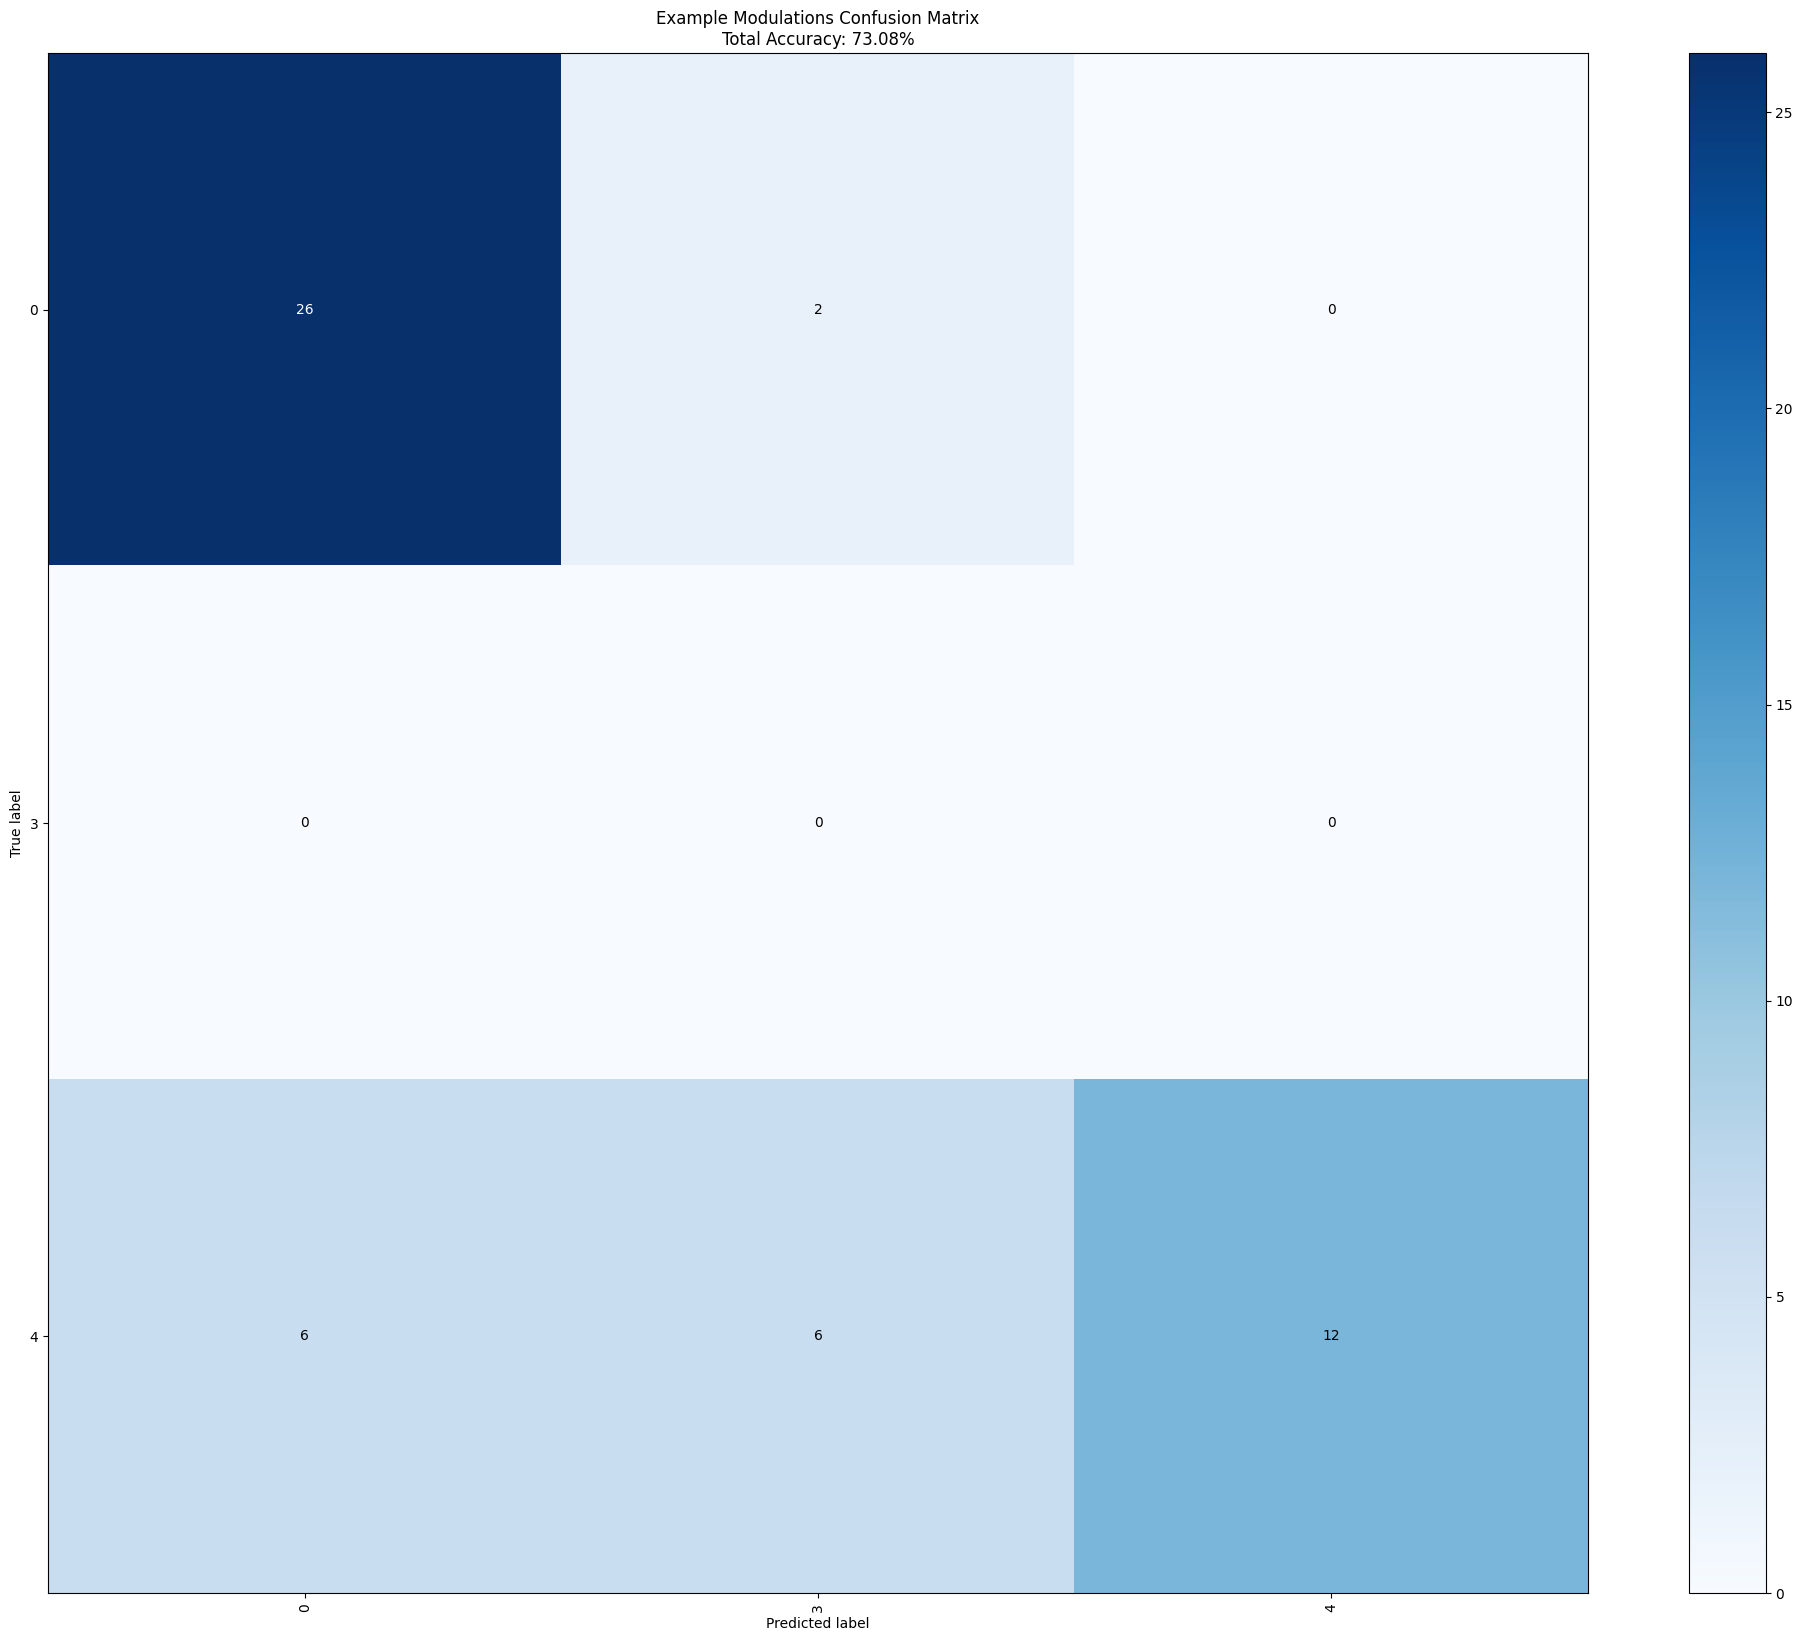

In [17]:
acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true, 
    y_preds, 
    classes=np.unique(y_preds),
    #classes=np.unique(np.concatenate((np.arange(len(dataset.class_list)),np.unique(y_preds)))),
    normalize=False,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=True,
    rotate_x_text=90,
    figsize=(26,20),
)
plt.show()